In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from RobustRandomForest import RobustRandomForest
from distribution import Distribution
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

# Пример запуска

In [33]:
dist = Distribution(_func=lambda x: x * np.sin(x), ro1=0.1, ro2=1.0, alpha=0.95)
X_train, X_test, Y_train, Y_test = dist.distribution([-6, 6], 500)
print(dist.sigma1)

0.048646282848607864


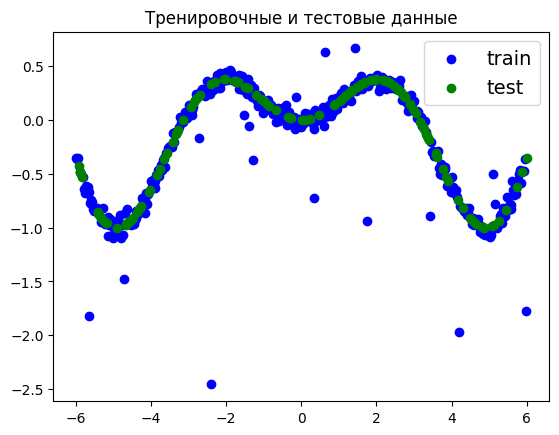

In [34]:
plt.title(f'Тренировочные и тестовые данные')
plt.scatter(X_train, Y_train, color='b', label='train')
plt.scatter(X_test, Y_test, color='g', label='test')
plt.legend(fontsize=14)
plt.show()

In [35]:
sk_rf = RandomForestRegressor(n_jobs=-1)
sk_rf.fit(X_train, Y_train)
sk_rf_pred = sk_rf.predict(X_test)
print(f'MAE sk_rf: {mean_absolute_error(sk_rf_pred, Y_test)}')
print(f'MSE sk_rf: {mean_squared_error(sk_rf_pred, Y_test)}')

MAE sk_rf: 0.06293459533650232
MSE sk_rf: 0.040275783702908394


In [36]:
huber_rrf = RobustRandomForest(n_jobs=-1, regression=True, delta=0.0005, robustness='huber')
huber_rrf.fit(X_train, Y_train)
huber_rrf_pred = huber_rrf.predict(X_test)
print(f'MAE huber_rrf: {mean_absolute_error(huber_rrf_pred, Y_test)}')
print(f'MSE huber_rrf: {mean_squared_error(huber_rrf_pred, Y_test)}')

MAE huber_rrf: 0.07205692246804182
MSE huber_rrf: 0.015029510271119935


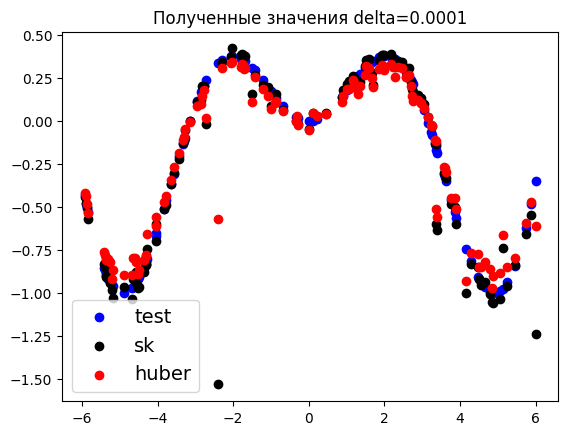

In [37]:
plt.title(f'Полученные значения delta={0.0001}')
plt.scatter(X_test, Y_test, color='b', label='test')
plt.scatter(X_test, sk_rf_pred, color='black', label='sk')
plt.scatter(X_test, huber_rrf_pred, color='r', label='huber')
plt.legend(fontsize=14)
plt.show()

In [42]:
lowess_rrf = RobustRandomForest(n_jobs=-1, regression=True, robustness='lowess')
lowess_rrf.fit(X_train, Y_train, alpha=20)
lowess_rrf_pred = lowess_rrf.predict(X_test)
print(f'MAE lowess_rrf: {mean_absolute_error(lowess_rrf_pred, Y_test)}')
print(f'MSE lowess_rrf: {mean_squared_error(lowess_rrf_pred, Y_test)}')

MAE lowess_rrf: 0.05783216943666732
MSE lowess_rrf: 0.03144042209799441


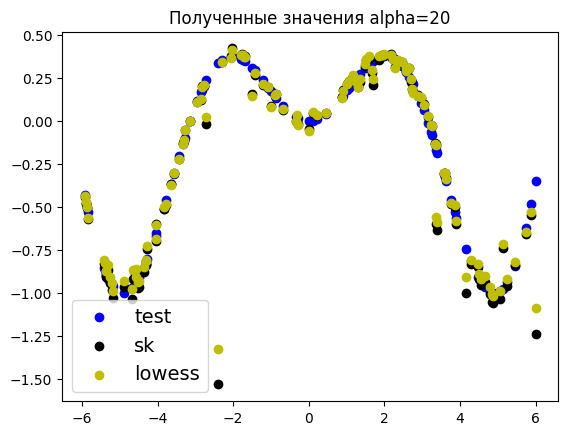

In [43]:
plt.title(f'Полученные значения alpha={20}')
plt.scatter(X_test, Y_test, color='b', label='test')
plt.scatter(X_test, sk_rf_pred, color='black', label='sk')
plt.scatter(X_test, lowess_rrf_pred, color='y', label='lowess')
plt.legend(fontsize=14)
plt.show()

# Подбираем параметр alpha

In [44]:
alphas = [6, 8, 10, 12, 14, 16, 20]
n = 10

In [45]:
lowess_mae = []
lowess_mse = []

for alpha in tqdm(alphas):

    mse, mae = [], []

    for _ in range(n):
        dist = Distribution(ro1=0.1, ro2=1.0, _func=lambda x: x * np.sin(x))
        X_train, X_test, Y_train, Y_test = dist.distribution([-6, 6], 500)

        lowess_rrf = RobustRandomForest(n_jobs=-1, regression=True, robustness='lowess')
        lowess_rrf.fit(X_train, Y_train, alpha=alpha)
        lowess_rrf_pred = lowess_rrf.predict(X_test)

        mae.append(mean_absolute_error(lowess_rrf_pred, Y_test))
        mse.append(mean_squared_error(lowess_rrf_pred, Y_test))

    lowess_mae.append(np.mean(mae))
    lowess_mse.append(np.mean(mse))

100%|██████████| 7/7 [15:07<00:00, 129.59s/it]


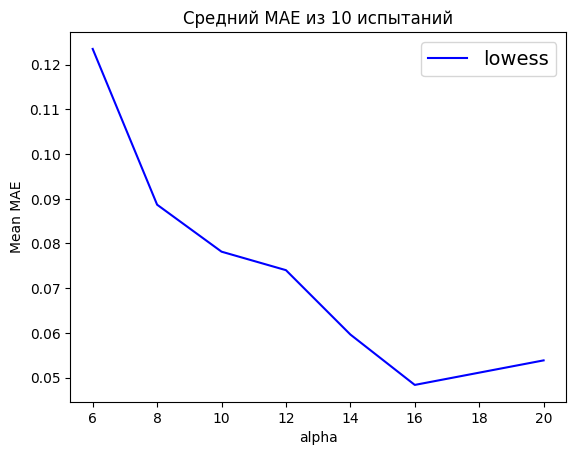

In [46]:
plt.title(f'Средний MAE из {n} испытаний')
plt.plot(alphas, lowess_mae, color='b', label='lowess')
plt.xlabel('alpha')
plt.ylabel('Mean MAE')
plt.legend(fontsize=14)
plt.show()

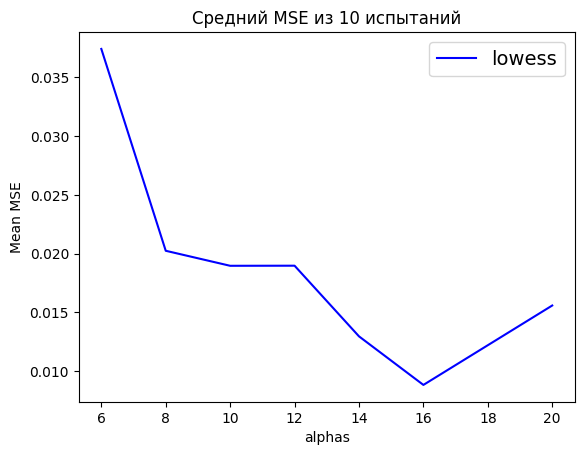

In [47]:
plt.title(f'Средний MSE из {n} испытаний')
plt.plot(alphas, lowess_mse, color='b', label='lowess')
plt.xlabel('alphas')
plt.ylabel('Mean MSE')
plt.legend(fontsize=14)
plt.show()

# Исследовние

## Списки интересующих нас переменных

In [ ]:
ros = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
dims = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
alphas = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]
noise_modules = [0.3, 0.5, 0.7, 0.9, 1.1, 1.3]
n = 500

## Исследовние зависимости МАЕ и MSE от меры шума 

In [3]:
delta = 0.0001
sk_mae, huber_mae, tukey_mae, lowess_mae = [], [], [], []
sk_mse, huber_mse, tukey_mse, lowess_mse = [], [], [], []

for ro in tqdm(ros):

    mae, mse = [], []

    for i in range(n):
        
        dist = Distribution(ro1=ro, ro2=1.0, _func=lambda x: x * np.sin(x))
        X_train, X_test, Y_train, Y_test = dist.distribution([-6, 6], 500)

        huber_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='huber', delta=delta)
        huber_rrf.fit(X_train, Y_train)
        huber_rrf_pred = huber_rrf.predict(X_test)
        mae.append(mean_absolute_error(huber_rrf_pred, Y_test))
        mse.append(mean_squared_error(huber_rrf_pred, Y_test))

        tukey_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='tukey', delta=delta)
        tukey_rrf.fit(X_train, Y_train)
        tukey_rrf_pred = tukey_rrf.predict(X_test)
        mae.append(mean_absolute_error(tukey_rrf_pred, Y_test))
        mse.append(mean_squared_error(tukey_rrf_pred, Y_test))

        lowess_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='lowess')
        lowess_rrf.fit(X_train, Y_train, alpha=20)
        lowess_rrf_pred = lowess_rrf.predict(X_test)
        mae.append(mean_absolute_error(lowess_rrf_pred, Y_test))
        mse.append(mean_squared_error(lowess_rrf_pred, Y_test))
        
        sk_rf = RandomForestRegressor(n_jobs=-1)
        sk_rf.fit(X_train, Y_train)
        sk_rf_pred = sk_rf.predict(X_test)
        mae.append(mean_absolute_error(sk_rf_pred, Y_test))
        mse.append(mean_squared_error(sk_rf_pred, Y_test))
    
    huber_mae.append(np.mean(mae[0: n*4:4]))
    tukey_mae.append(np.mean(mae[1: n*4:4]))
    lowess_mae.append(np.mean(mae[2: n*4:4]))
    sk_mae.append(np.mean(mae[3: n*4:4]))

    huber_mse.append(np.mean(mae[0: n*4:4]))
    tukey_mse.append(np.mean(mae[1: n*4:4]))
    lowess_mse.append(np.mean(mae[2: n*4:4]))
    sk_mse.append(np.mean(mae[3: n*4:4]))

100%|██████████| 7/7 [03:00<00:00, 25.78s/it]


In [4]:
ros_range_data = {'ros': ros, 
      'huber_mae': huber_mae, 
      'tukey_mae': tukey_mae,
      'lowess_mae': lowess_mae,
      'sk_mae': sk_mae,
      'huber_mse': tukey_mae,
      'tukey_mse': tukey_mse,
      'lowess_mse': lowess_mse,
      'sk_mse': sk_mse}

df = pd.DataFrame(ros_range_data)
df.to_csv('ros_range_data.csv')

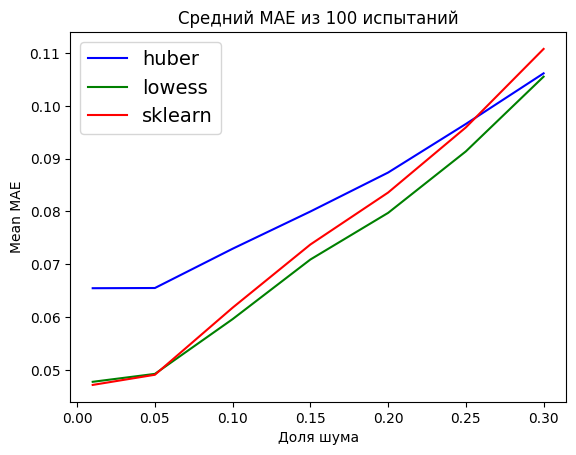

In [54]:
plt.title(f'Средний MAE из {n} испытаний')
plt.plot(ros, huber_mae, color='b', label='huber')
plt.plot(ros, lowess_mae, color='g', label='lowess')
plt.plot(ros, sk_mae, color='r', label='sklearn')
plt.xlabel('Доля шума')
plt.ylabel('Mean MAE')
plt.legend(fontsize=14)
plt.show()

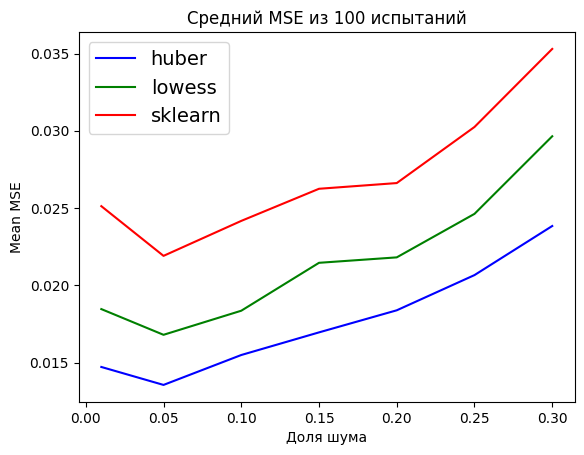

In [55]:
plt.title(f'Средний MSE из {n} испытаний')
plt.plot(ros, huber_mse, color='b', label='huber')
plt.plot(ros, lowess_mse, color='g', label='lowess')
plt.plot(ros, sk_mse, color='r', label='sklearn')
plt.xlabel('Доля шума')
plt.ylabel('Mean MSE')
plt.legend(fontsize=14)
plt.show()

## Исследовние зависимости МАЕ и MSE от размерности выборки

In [ ]:
delta = 0.0001
sk_mae, huber_mae, lowess_mae = [], [], []
sk_mse, huber_mse, lowess_mse = [], [], []

for dim in tqdm(dims):

    mae, mse = [], []

    for i in range(n):
        
        dist = Distribution(ro1=0.1, ro2=1.0, _func=lambda x: x * np.sin(x))
        X_train, X_test, Y_train, Y_test = dist.distribution([-6, 6], dim)

        huber_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='huber', delta=delta)
        huber_rrf.fit(X_train, Y_train)
        huber_rrf_pred = huber_rrf.predict(X_test)
        mae.append(mean_absolute_error(huber_rrf_pred, Y_test))
        mse.append(mean_squared_error(huber_rrf_pred, Y_test))

        tukey_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='tukey', delta=delta)
        tukey_rrf.fit(X_train, Y_train)
        tukey_rrf_pred = tukey_rrf.predict(X_test)
        mae.append(mean_absolute_error(tukey_rrf_pred, Y_test))
        mse.append(mean_squared_error(tukey_rrf_pred, Y_test))

        lowess_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='lowess')
        lowess_rrf.fit(X_train, Y_train, alpha=20)
        lowess_rrf_pred = lowess_rrf.predict(X_test)
        mae.append(mean_absolute_error(lowess_rrf_pred, Y_test))
        mse.append(mean_squared_error(lowess_rrf_pred, Y_test))
        
        sk_rf = RandomForestRegressor(n_jobs=-1)
        sk_rf.fit(X_train, Y_train)
        sk_rf_pred = sk_rf.predict(X_test)
        mae.append(mean_absolute_error(sk_rf_pred, Y_test))
        mse.append(mean_squared_error(sk_rf_pred, Y_test))
    
    huber_mae.append(np.mean(mae[0: n*4:4]))
    tukey_mae.append(np.mean(mae[1: n*4:4]))
    lowess_mae.append(np.mean(mae[2: n*4:4]))
    sk_mae.append(np.mean(mae[3: n*4:4]))

    huber_mse.append(np.mean(mae[0: n*4:4]))
    tukey_mse.append(np.mean(mae[1: n*4:4]))
    lowess_mse.append(np.mean(mae[2: n*4:4]))
    sk_mse.append(np.mean(mae[3: n*4:4]))

100%|██████████| 10/10 [4:51:41<00:00, 1750.14s/it] 


In [ ]:
dims_range_data = {'dims': dims, 
      'huber_mae': huber_mae, 
      'tukey_mae': tukey_mae,
      'lowess_mae': lowess_mae,
      'sk_mae': sk_mae,
      'huber_mse': tukey_mae,
      'tukey_mse': tukey_mse,
      'lowess_mse': lowess_mse,
      'sk_mse': sk_mse}

df = pd.DataFrame(dims_range_data)
df.to_csv('dims_range_data.csv')

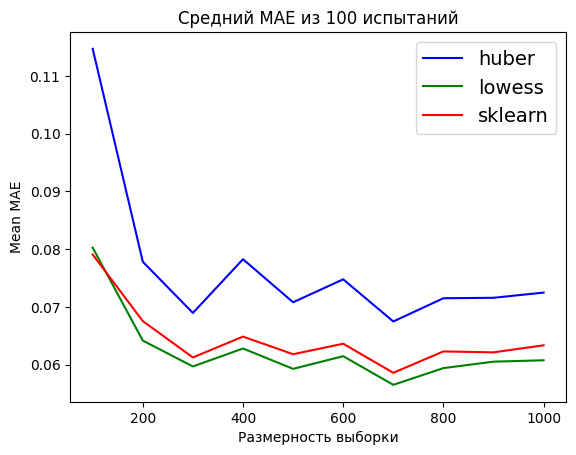

In [57]:
plt.title(f'Средний MAE из {n} испытаний')
plt.plot(dims, huber_mae, color='b', label='huber')
plt.plot(dims, lowess_mae, color='g', label='lowess')
plt.plot(dims, sk_mae, color='r', label='sklearn')
plt.xlabel('Размерность выборки')
plt.ylabel('Mean MAE')
plt.legend(fontsize=14)
plt.show()

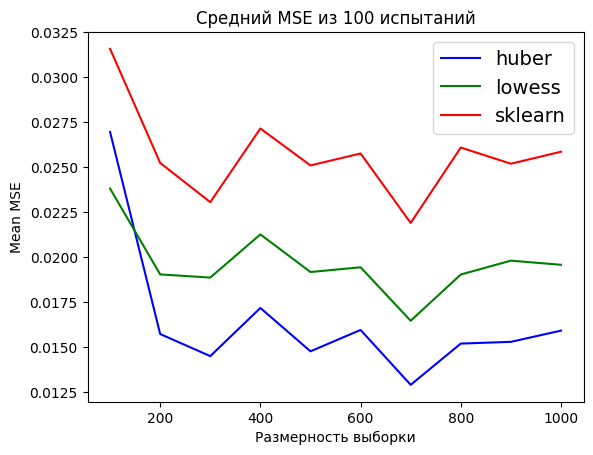

In [58]:
plt.title(f'Средний MSE из {n} испытаний')
plt.plot(dims, huber_mse, color='b', label='huber')
plt.plot(dims, lowess_mse, color='g', label='lowess')
plt.plot(dims, sk_mse, color='r', label='sklearn')
plt.xlabel('Размерность выборки')
plt.ylabel('Mean MSE')
plt.legend(fontsize=14)
plt.show()

## Исследовние зависимости МАЕ и MSE от параметра смеси

In [ ]:
delta = 0.0001
sk_mae, huber_mae, lowess_mae = [], [], []
sk_mse, huber_mse, lowess_mse = [], [], []

for alpha in tqdm(alphas):

    mae, mse = [], []

    for i in range(n):
        
        dist = Distribution(alpha=alpha, ro2=1.0, _func=lambda x: x * np.sin(x))
        X_train, X_test, Y_train, Y_test = dist.distribution([-6, 6], 500)

        huber_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='huber', delta=delta)
        huber_rrf.fit(X_train, Y_train)
        huber_rrf_pred = huber_rrf.predict(X_test)
        mae.append(mean_absolute_error(huber_rrf_pred, Y_test))
        mse.append(mean_squared_error(huber_rrf_pred, Y_test))

        tukey_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='tukey', delta=delta)
        tukey_rrf.fit(X_train, Y_train)
        tukey_rrf_pred = tukey_rrf.predict(X_test)
        mae.append(mean_absolute_error(tukey_rrf_pred, Y_test))
        mse.append(mean_squared_error(tukey_rrf_pred, Y_test))

        lowess_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='lowess')
        lowess_rrf.fit(X_train, Y_train, alpha=20)
        lowess_rrf_pred = lowess_rrf.predict(X_test)
        mae.append(mean_absolute_error(lowess_rrf_pred, Y_test))
        mse.append(mean_squared_error(lowess_rrf_pred, Y_test))
        
        sk_rf = RandomForestRegressor(n_jobs=-1)
        sk_rf.fit(X_train, Y_train)
        sk_rf_pred = sk_rf.predict(X_test)
        mae.append(mean_absolute_error(sk_rf_pred, Y_test))
        mse.append(mean_squared_error(sk_rf_pred, Y_test))
    
    huber_mae.append(np.mean(mae[0: n*4:4]))
    tukey_mae.append(np.mean(mae[1: n*4:4]))
    lowess_mae.append(np.mean(mae[2: n*4:4]))
    sk_mae.append(np.mean(mae[3: n*4:4]))

    huber_mse.append(np.mean(mae[0: n*4:4]))
    tukey_mse.append(np.mean(mae[1: n*4:4]))
    lowess_mse.append(np.mean(mae[2: n*4:4]))
    sk_mse.append(np.mean(mae[3: n*4:4]))

100%|██████████| 10/10 [3:38:21<00:00, 1310.18s/it] 


In [ ]:
alphas_range_data = {'alphas': alphas, 
      'huber_mae': huber_mae, 
      'tukey_mae': tukey_mae,
      'lowess_mae': lowess_mae,
      'sk_mae': sk_mae,
      'huber_mse': tukey_mae,
      'tukey_mse': tukey_mse,
      'lowess_mse': lowess_mse,
      'sk_mse': sk_mse}

df = pd.DataFrame(alphas_range_data)
df.to_csv('alphas_range_data.csv')

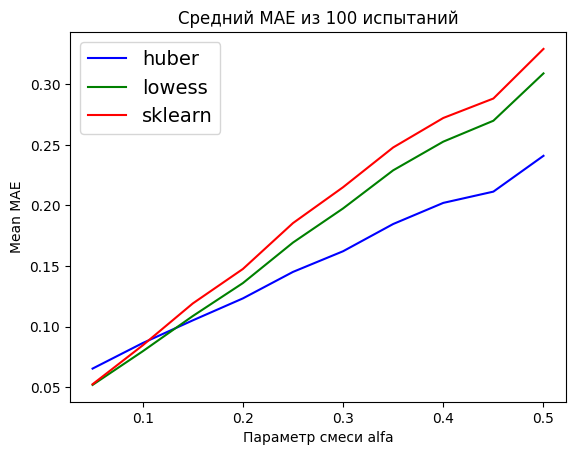

In [ ]:
plt.title(f'Средний MAE из {n} испытаний')
plt.plot((1-np.array([alphas])).reshape(10,), huber_mae, color='b', label='huber')
plt.plot((1-np.array([alphas])).reshape(10,), lowess_mae, color='g', label='lowess')
plt.plot((1-np.array([alphas])).reshape(10,), sk_mae, color='r', label='sklearn')
plt.xlabel('Параметр смеси alpha')
plt.ylabel('Mean MAE')
plt.legend(fontsize=14)
plt.show()

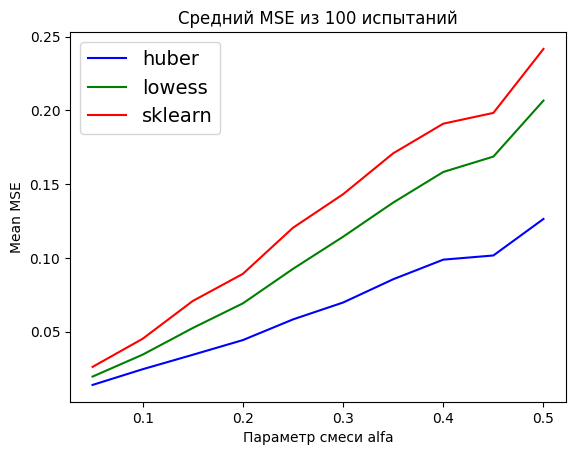

In [ ]:
plt.title(f'Средний MSE из {n} испытаний')
plt.plot((1-np.array([alphas])).reshape(10,), huber_mse, color='b', label='huber')
plt.plot((1-np.array([alphas])).reshape(10,), lowess_mse, color='g', label='lowess')
plt.plot((1-np.array([alphas])).reshape(10,), sk_mse, color='r', label='sklearn')
plt.xlabel('Параметр смеси alpha')
plt.ylabel('Mean MSE')
plt.legend(fontsize=14)
plt.show()

## Исследовние зависимости МАЕ и MSE от модуля выбросов

In [ ]:
delta = 0.0001
sk_mae, huber_mae, lowess_mae = [], [], []
sk_mse, huber_mse, lowess_mse = [], [], []

for noise_module in tqdm(noise_modules):

    mae, mse = [], []

    for i in range(n):
        
        dist = Distribution(alpha=0.9, ro2=noise_module, _func=lambda x: x * np.sin(x))
        X_train, X_test, Y_train, Y_test = dist.distribution([-6, 6], 500)

        huber_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='huber', delta=delta)
        huber_rrf.fit(X_train, Y_train)
        huber_rrf_pred = huber_rrf.predict(X_test)
        mae.append(mean_absolute_error(huber_rrf_pred, Y_test))
        mse.append(mean_squared_error(huber_rrf_pred, Y_test))

        tukey_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='tukey', delta=delta)
        tukey_rrf.fit(X_train, Y_train)
        tukey_rrf_pred = tukey_rrf.predict(X_test)
        mae.append(mean_absolute_error(tukey_rrf_pred, Y_test))
        mse.append(mean_squared_error(tukey_rrf_pred, Y_test))

        lowess_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='lowess')
        lowess_rrf.fit(X_train, Y_train, alpha=20)
        lowess_rrf_pred = lowess_rrf.predict(X_test)
        mae.append(mean_absolute_error(lowess_rrf_pred, Y_test))
        mse.append(mean_squared_error(lowess_rrf_pred, Y_test))
        
        sk_rf = RandomForestRegressor(n_jobs=-1)
        sk_rf.fit(X_train, Y_train)
        sk_rf_pred = sk_rf.predict(X_test)
        mae.append(mean_absolute_error(sk_rf_pred, Y_test))
        mse.append(mean_squared_error(sk_rf_pred, Y_test))
    
    huber_mae.append(np.mean(mae[0: n*4:4]))
    tukey_mae.append(np.mean(mae[1: n*4:4]))
    lowess_mae.append(np.mean(mae[2: n*4:4]))
    sk_mae.append(np.mean(mae[3: n*4:4]))

    huber_mse.append(np.mean(mae[0: n*4:4]))
    tukey_mse.append(np.mean(mae[1: n*4:4]))
    lowess_mse.append(np.mean(mae[2: n*4:4]))
    sk_mse.append(np.mean(mae[3: n*4:4]))

100%|██████████| 6/6 [2:30:59<00:00, 1509.99s/it]  


In [ ]:
noise_modules_range_data = {'noise_modules': noise_modules, 
      'huber_mae': huber_mae, 
      'tukey_mae': tukey_mae,
      'lowess_mae': lowess_mae,
      'sk_mae': sk_mae,
      'huber_mse': tukey_mae,
      'tukey_mse': tukey_mse,
      'lowess_mse': lowess_mse,
      'sk_mse': sk_mse}

df = pd.DataFrame(noise_modules_range_data)
df.to_csv('noise_modules_range_data.csv')

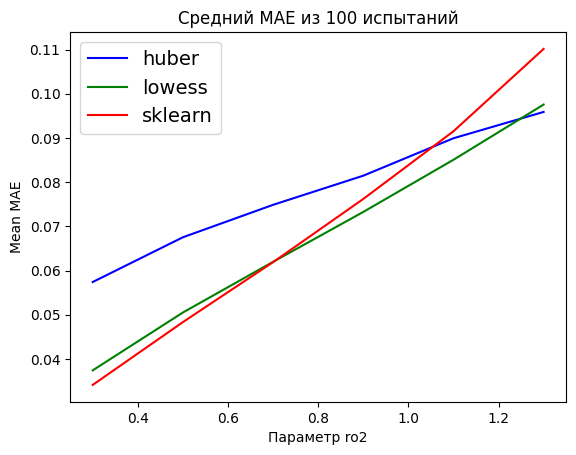

In [63]:
plt.title(f'Средний MAE из {n} испытаний')
plt.plot(noise_modules, huber_mae, color='b', label='huber')
plt.plot(noise_modules, lowess_mae, color='g', label='lowess')
plt.plot(noise_modules, sk_mae, color='r', label='sklearn')
plt.xlabel('Параметр ro2')
plt.ylabel('Mean MAE')
plt.legend(fontsize=14)
plt.show()

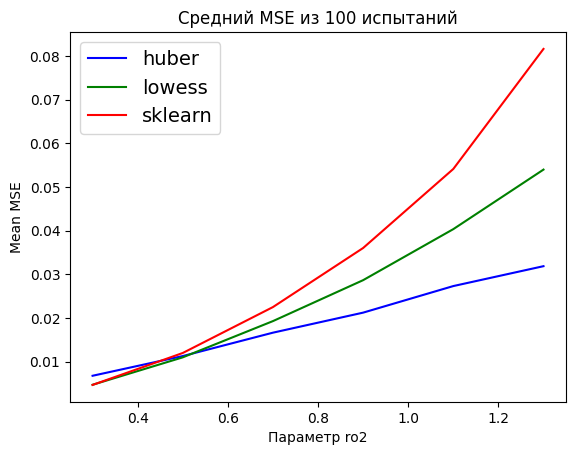

In [64]:
plt.title(f'Средний MSE из {n} испытаний')
plt.plot(noise_modules, huber_mse, color='b', label='huber')
plt.plot(noise_modules, lowess_mse, color='g', label='lowess')
plt.plot(noise_modules, sk_mse, color='r', label='sklearn')
plt.xlabel('Параметр ro2')
plt.ylabel('Mean MSE')
plt.legend(fontsize=14)
plt.show()